In [1]:
import pandas as pd
import numpy as np
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, select_columns, reshape_dataset, fillna_dataset
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.XGBoost_Model_Module import Xgboost_model
from ipynb.fs.defs.Model_Validation_Module import test_model_random_split, train_model_KFold, operational_validation, predict

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Greece/GRE_culex_2011_2022.csv')
#=====================================================================
data = data[data.nuts2_name == 'CRETE']
data = data.reset_index(drop=True)
#=====================================================================
columns = ['dt_placement', 'x', 'y', 'culex spp.', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/greece_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/greece_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['trap_id', 'station_id', 'x', 'y', 'dt_placement', 'week', 'month',
       'year', 'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code',
       'nuts1_name', 'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex spp.',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_m

In [4]:
# set the only_env as True if you want to use only environmental features
only_env = False
# set the case title
case_title = 'Culex Greece'
# set the exp as True if you want to save the results as csv
exp = False
# set the filepath to export the data
path = '../Results/Culex Greece/'
# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'
# set the transform argument as True if you want to limit the target variable to 0-9 scale
transform_target = False
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the transformation actions of the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []

In [5]:
data = feature_expansion(data, env=only_env)

In [6]:
data = initializer(data, model_type, [-1,   0.,  1.,  2.,  3., 6., 14., 27., 35., 50., np.inf], dropna=True)

Bounds: [-1.  0.  1.  2.  3.  6. 14. 27. 35. 50. inf]


In [7]:
model = Xgboost_model(model_type = model_type, learning_rate = 0.3,
                      embedding_data = embedded_data,  transformation_list = transformation_list,
                      early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)

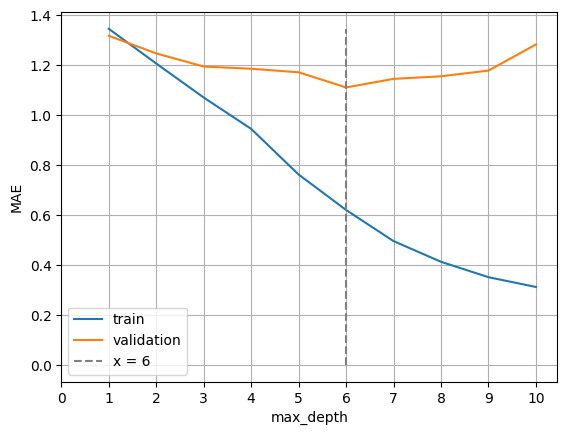

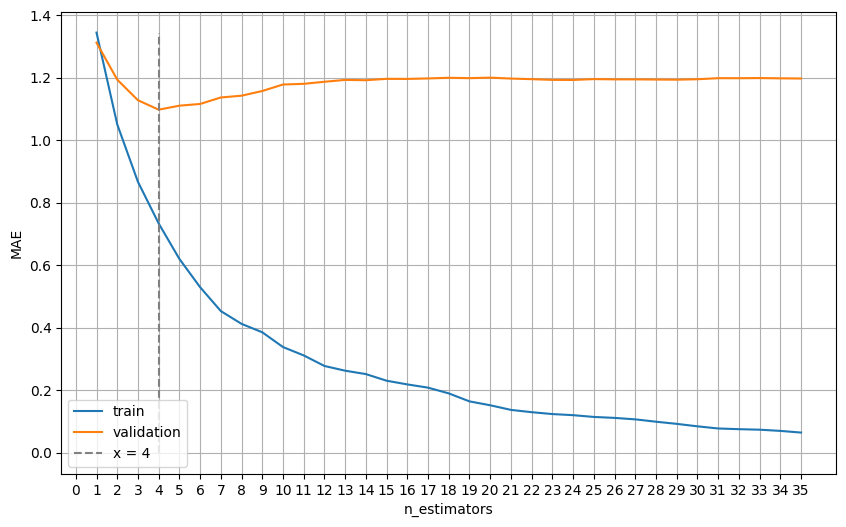

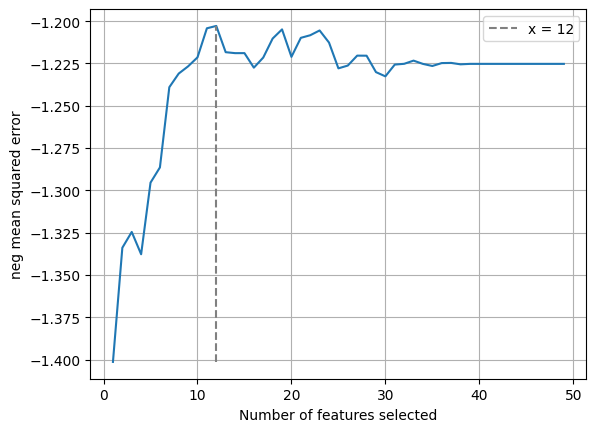

max_depth:  6
Number of estimators:  4
Selected_features:  Index(['y', 'lst_jan_day_mean', 'lst_mar_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'DISTANCE_TO_COAST',
       'HILLSHADE_mean_1km', 'mo_cos', 'lst', 'mosq_sum_month',
       'mosq_sum_month_previous_year'],
      dtype='object')


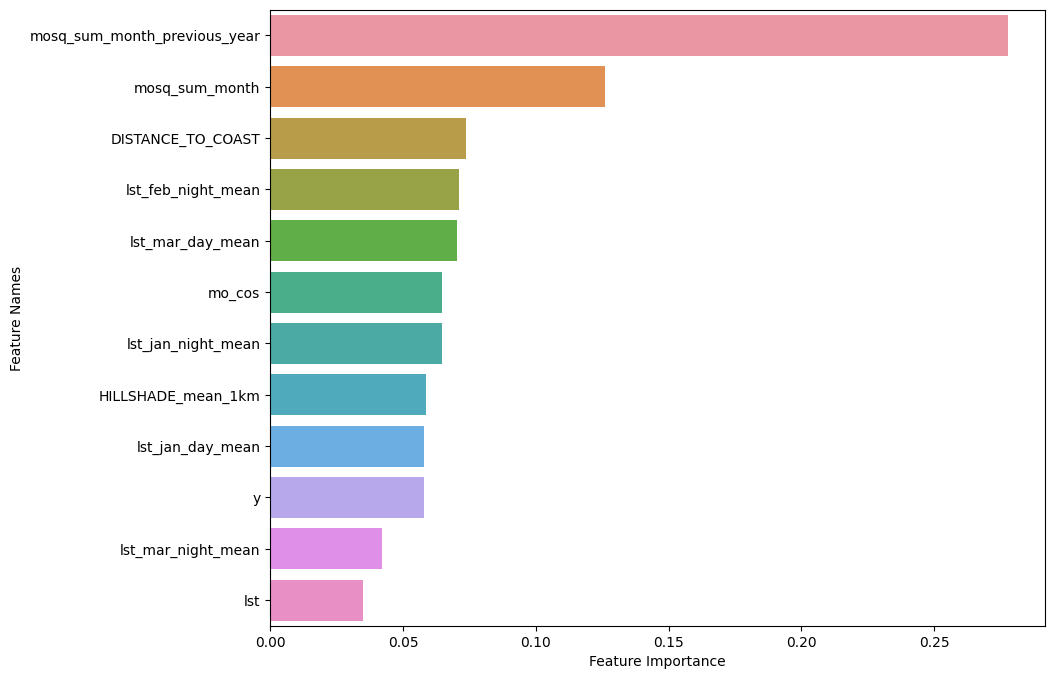

MAE on train set:  0.7762237762237763
min prediction: 0.0
max prediction: 6.0

MAE on test set:  1.1942446043165467
Error <= 3: 96.40 %
min prediction: 0.0
max prediction: 4.0


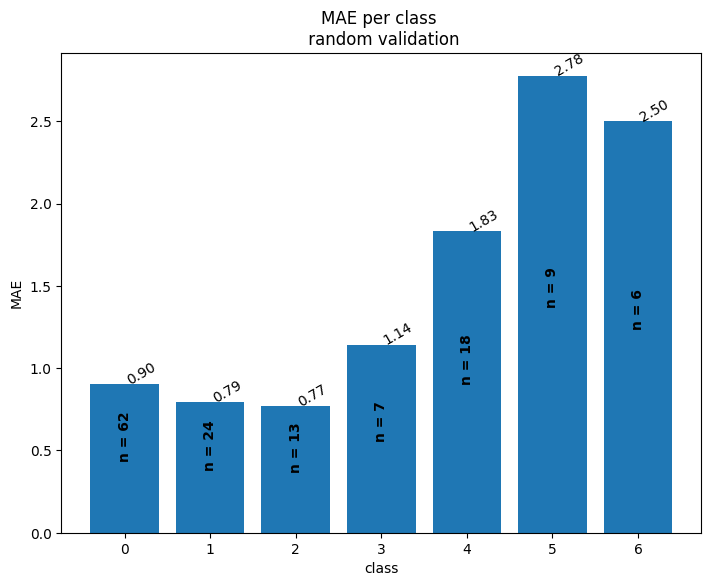

-----------|class error-MAE| difference-----------
mean: 1.0482091513197507
std: 0.669317075376043
coefficient of variation (std/mean): 0.638533898061601

----------normalized difference-------------
mean: 0.6056319540958557
std: 0.3867165324394915
coefficient of variation (std/mean): 0.6385338980616013


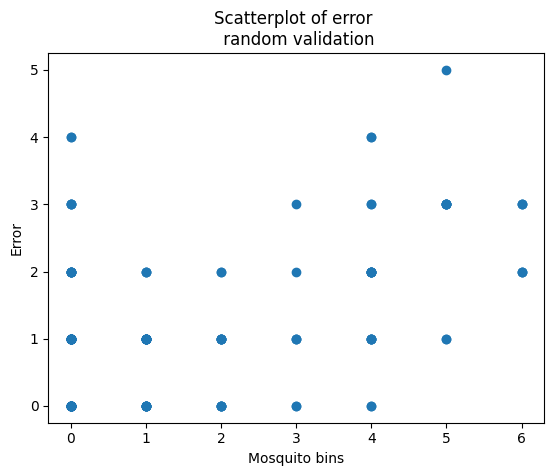

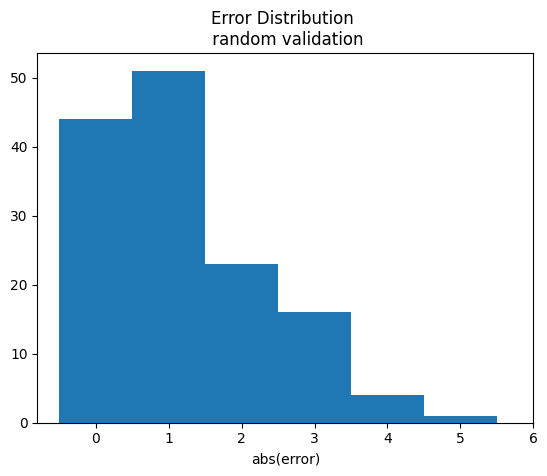

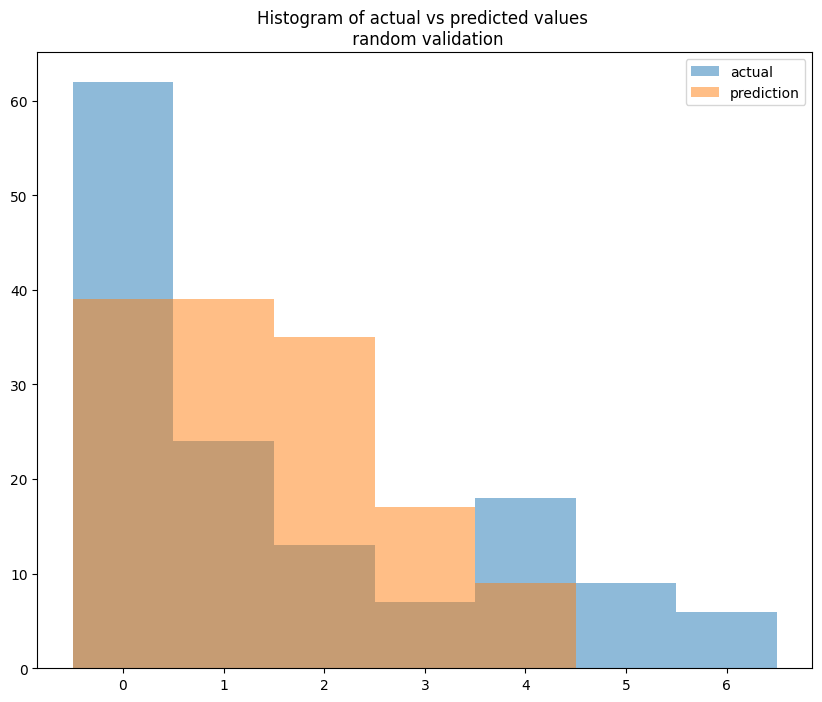

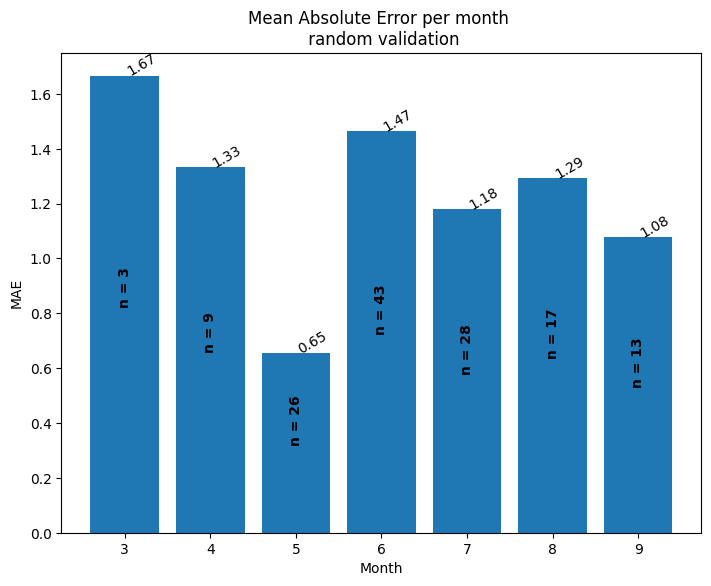

In [8]:
test_model_random_split(data, model, filepath = '', date_col = date_col, case='', fi = True, export=exp)

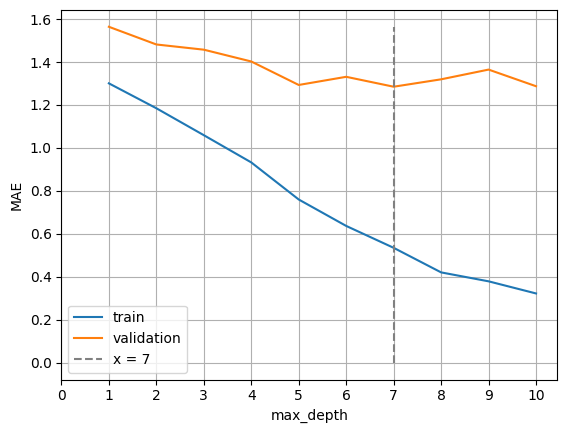

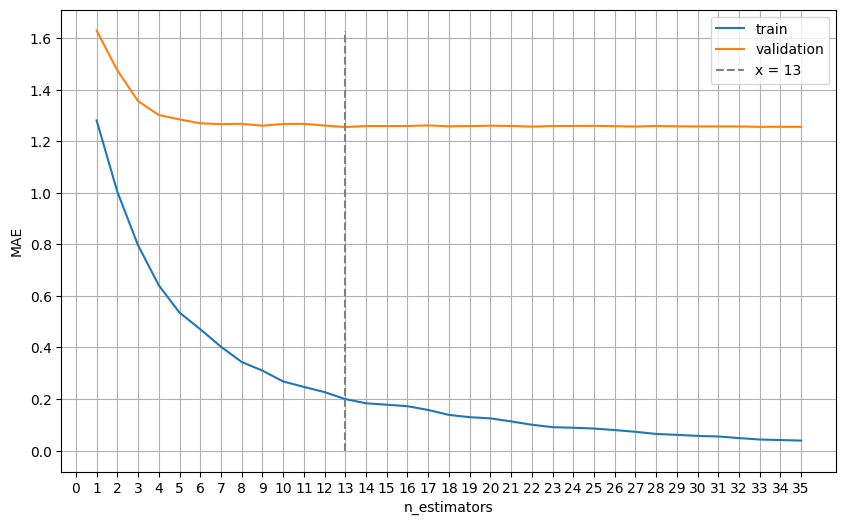

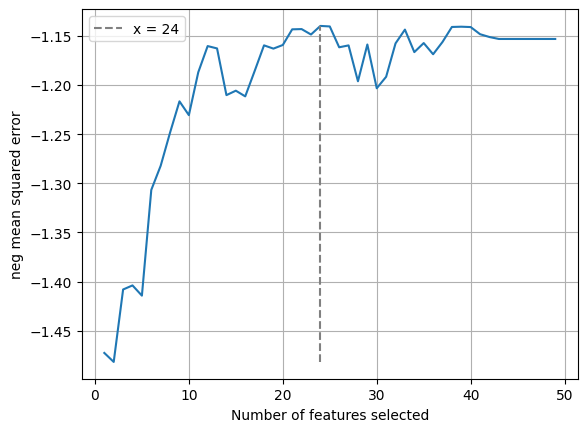

max_depth:  7
Number of estimators:  13
Selected_features:  Index(['ndmi_std', 'lst_day', 'lst_night', 'acc_rainfall_1week',
       'acc_rainfall_2week', 'acc_rainfall_jan', 'lst_jan_day_mean',
       'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
       'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean',
       'lst_apr_night_mean', 'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER',
       'ASPECT_mean_200m', 'HILLSHADE_mean_1km', 'days_distance', 'lst',
       'mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks'],
      dtype='object')
MAE on train set:  0.13781592751549834
min prediction: 0.0
max prediction: 8.0

MAE on test set:  1.0929899856938483
Error <= 3: 97.71 %
min prediction: 0.0
max prediction: 7.0


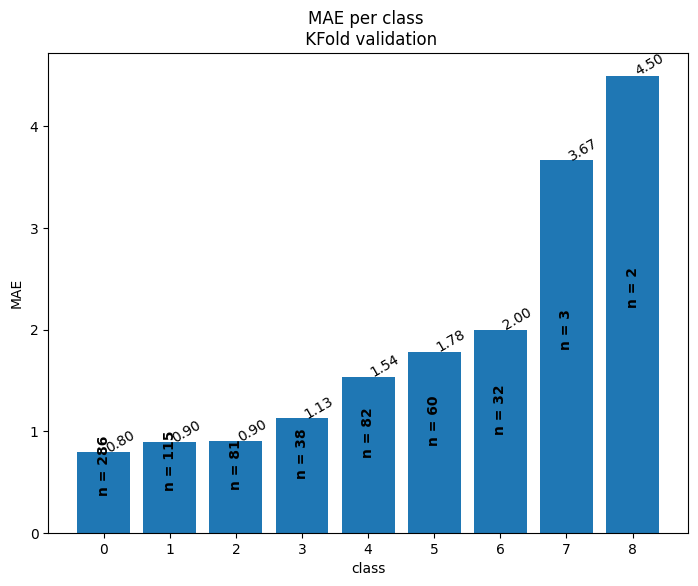

-----------|class error-MAE| difference-----------
mean: 2.587527349751205
std: 1.2404422080783963
coefficient of variation (std/mean): 0.4793928876530201

----------normalized difference-------------
mean: 0.6988034202349807
std: 0.33500138952825437
coefficient of variation (std/mean): 0.47939288765302024


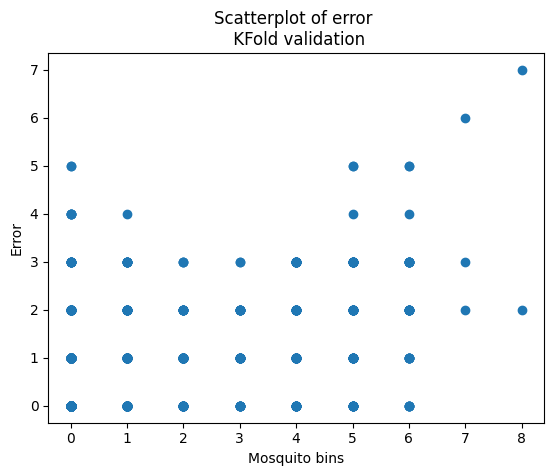

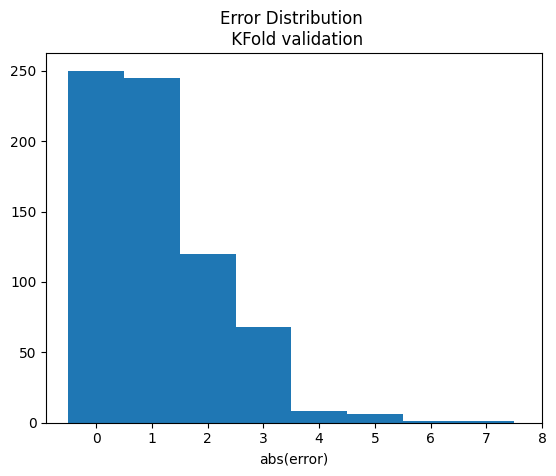

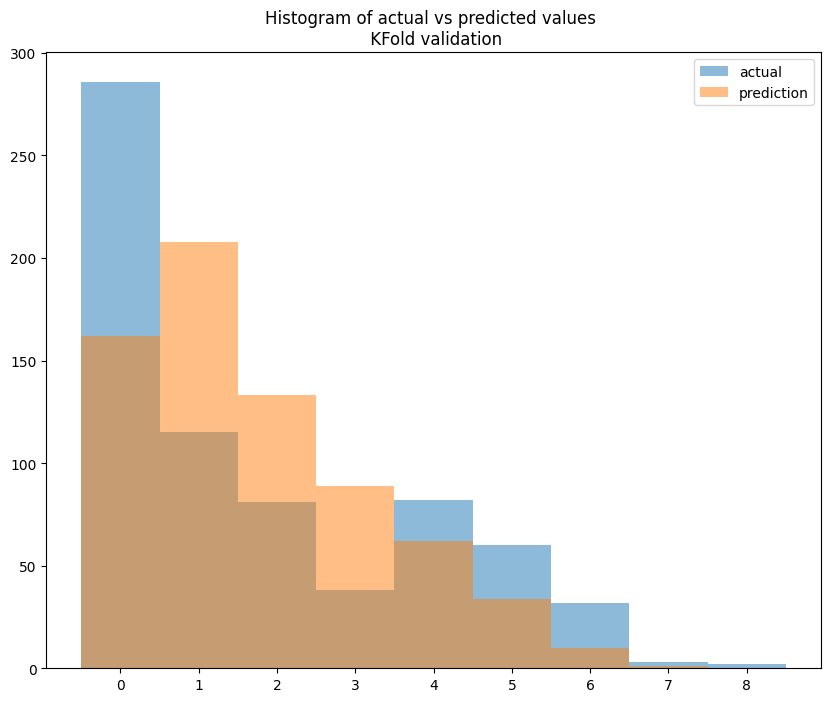

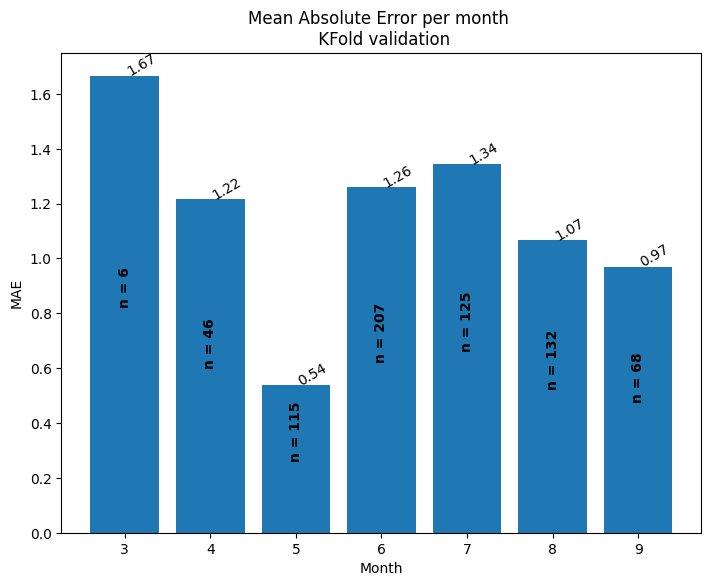

In [9]:
train_model_KFold(data, model, date_col=date_col)

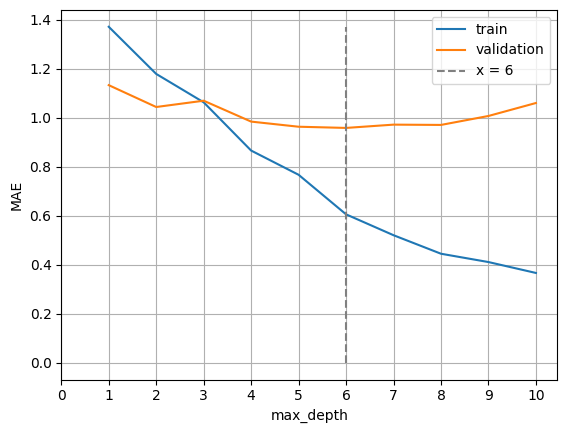

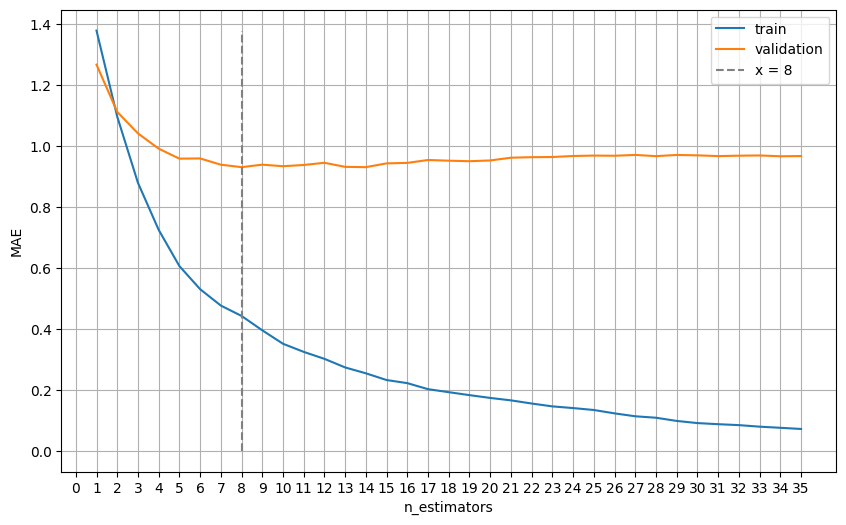

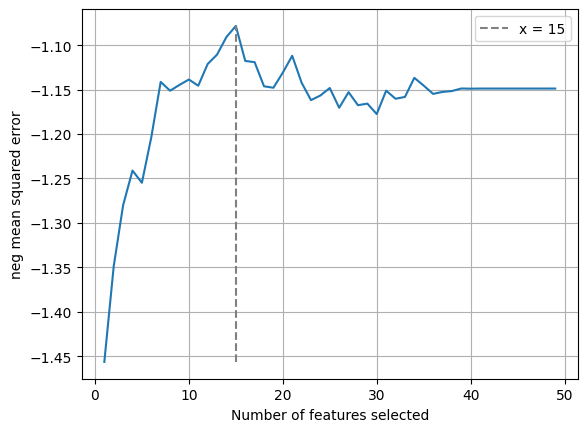

max_depth:  6
Number of estimators:  8
Selected_features:  Index(['acc_rainfall_2week', 'acc_rainfall_jan', 'lst_jan_day_mean',
       'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
       'lst_mar_night_mean', 'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER',
       'ASPECT_mean_200m', 'days_distance', 'lst',
       'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks'],
      dtype='object')
2022
MAE on train set:  0.496661101836394
min prediction: 0.0
max prediction: 7.0

MAE on test set:  1.4591836734693877
Error <= 3: 95.41 %
min prediction: 0.0
max prediction: 5.0


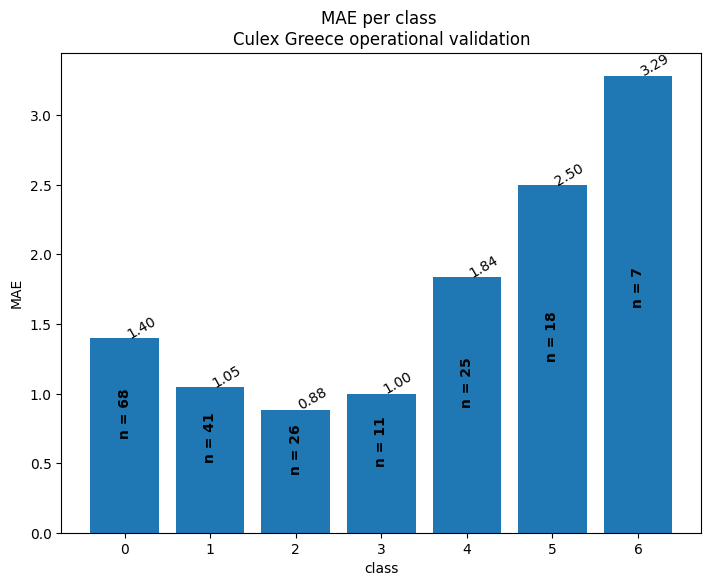

-----------|class error-MAE| difference-----------
mean: 1.577690145476577
std: 0.8318955436319978
coefficient of variation (std/mean): 0.527287025286391

----------normalized difference-------------
mean: 0.6570700377042037
std: 0.34646450558586633
coefficient of variation (std/mean): 0.527287025286391


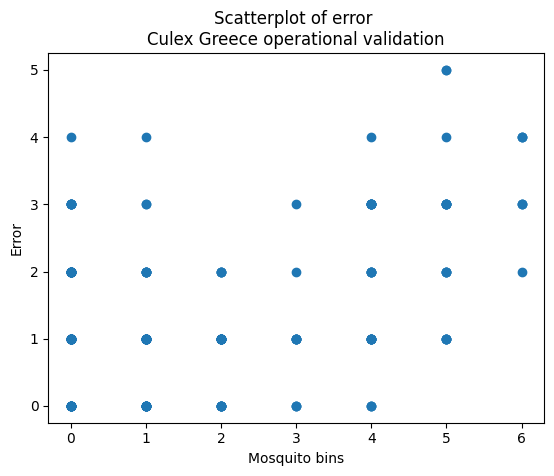

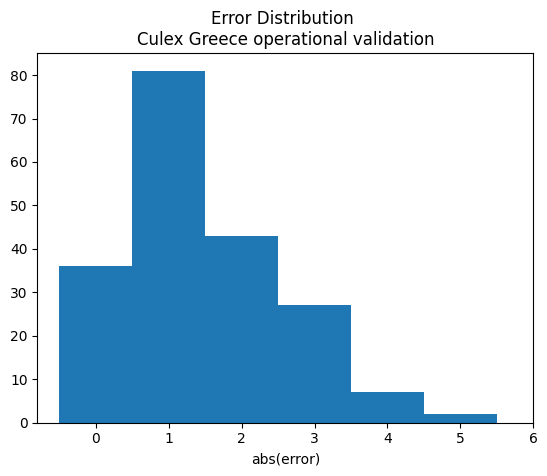

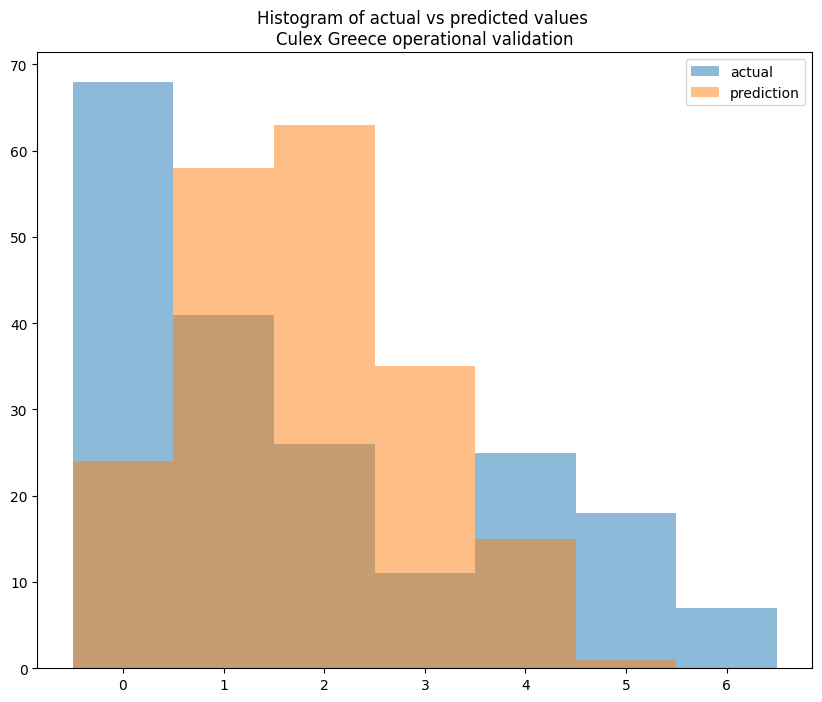

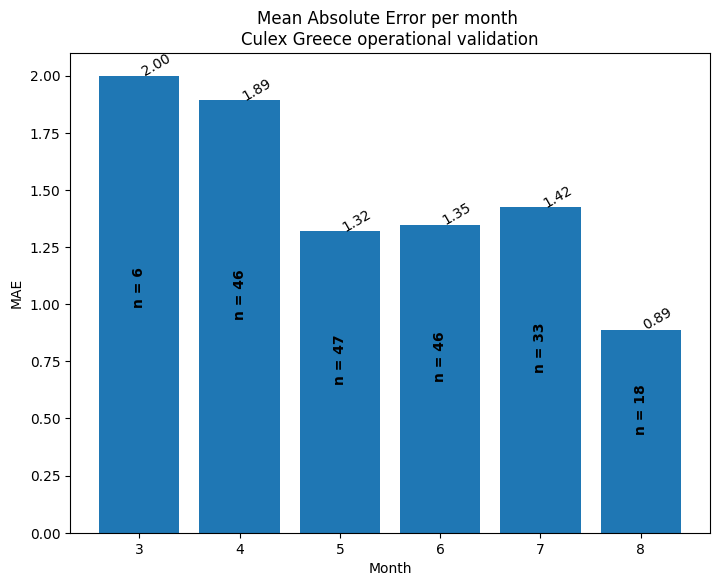

In [10]:
operational_validation(data, model, filepath = path, date_col = date_col,
                       date = '2022-01-01', case = case_title, export= exp)